# Facebook Prophet

<a href="https://facebook.github.io/prophet/">Prophet</a> is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

from fbprophet import Prophet

matplotlib.rcParams['figure.figsize'] = (12, 8)
pd.options.display.max_columns = 999

# Load Dataset

In [2]:
hec = pd.read_csv('../datasets/household-electricity.csv', parse_dates=[0])
print(hec.shape)
hec.head()

(26305, 322)


,DateTime,household_0,household_1,household_2,household_3,household_4,household_5,household_6,household_7,household_8,household_9,household_10,household_11,household_12,household_13,household_14,household_15,household_16,household_17,household_18,household_19,household_20,household_21,household_22,household_23,household_24,household_25,household_26,household_27,household_28,household_29,household_30,household_31,household_32,household_33,household_34,household_35,household_36,household_37,household_38,household_39,household_40,household_41,household_42,household_43,household_44,household_45,household_46,household_47,household_48,household_49,household_50,household_51,household_52,household_53,household_54,household_55,household_56,household_57,household_58,household_59,household_60,household_61,household_62,household_63,household_64,household_65,household_66,household_67,household_68,household_69,household_70,household_71,household_72,household_73,household_74,household_75,household_76,household_77,household_78,household_79,household_80,household_81,household_82,household_83,household_84,household_85,household_86,household_87,household_88,household_89,household_90,household_91,household_92,household_93,household_94,household_95,household_96,household_97,household_98,household_99,household_100,household_101,household_102,household_103,household_104,household_105,household_106,household_107,household_108,household_109,household_110,household_111,household_112,household_113,household_114,household_115,household_116,household_117,household_118,household_119,household_120,household_121,household_122,household_123,household_124,household_125,household_126,household_127,household_128,household_129,household_130,household_131,household_132,household_133,household_134,household_135,household_136,household_137,household_138,household_139,household_140,household_141,household_142,household_143,household_144,household_145,household_146,household_147,household_148,household_149,household_150,household_151,household_152,household_153,household_154,household_155,household_156,household_157,household_158,household_159,household_160,household_161,household_162,household_163,household_164,household_165,household_166,household_167,household_168,household_169,household_170,household_171,household_172,household_173,household_174,household_175,household_176,household_177,household_178,household_179,household_180,household_181,household_182,household_183,household_184,household_185,household_186,household_187,household_188,household_189,household_190,household_191,household_192,household_193,household_194,household_195,household_196,household_197,household_198,household_199,household_200,household_201,household_202,household_203,household_204,household_205,household_206,household_207,household_208,household_209,household_210,household_211,household_212,household_213,household_214,household_215,household_216,household_217,household_218,household_219,household_220,household_221,household_222,household_223,household_224,household_225,household_226,household_227,household_228,household_229,household_230,household_231,household_232,household_233,household_234,household_235,household_236,household_237,household_238,household_239,household_240,household_241,household_242,household_243,household_244,household_245,household_246,household_247,household_248,household_249,household_250,household_251,household_252,household_253,household_254,household_255,household_256,household_257,household_258,household_259,household_260,household_261,household_262,household_263,household_264,household_265,household_266,household_267,household_268,household_269,household_270,household_271,household_272,household_273,household_274,household_275,household_276,household_277,household_278,household_279,household_280,household_281,household_282,household_283,household_284,household_285,household_286,household_287,household_288,household_289,household_290,household_291,household_29

# Example Prophet Models

Exploration of how Prophet works with various implementations.

Prophet requires data in a specific format: a column 'ds' containing the DateTime values of each observation, and a target column 'y'. We will resample to an hourly time frequency to make the size of our dataset more manageable.

In [3]:
df_ex = hec.iloc[:, :2]
df_ex.columns = ['ds', 'y']
print(df_ex.shape)
df_ex.head()

(26305, 2)


,ds,y
0,2012-01-01 00:00:00,12.690355
1,2012-01-01 01:00:00,16.497462
2,2012-01-01 02:00:00,19.035533
3,2012-01-01 03:00:00,17.766497
4,2012-01-01 04:00:00,19.035533


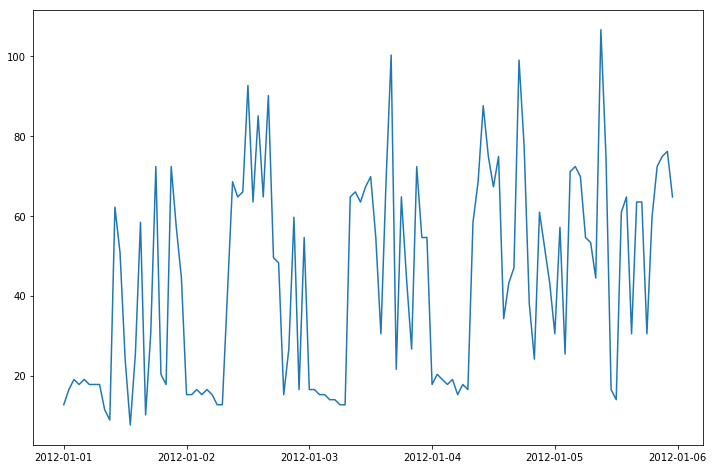

In [4]:
# Visualise data from first five days
plt.plot(df_ex['ds'][:120], df_ex['y'][:120]);

We'll test on the final 500 rows of data and use the 5000 rows before if for training (to keep the dataset at a manageable size).

In [5]:
test_length = 500
train_length = 5000

## Model 1 - Prophet Default

The first model is a vanilla implementation of Prophet. We start by instantiating the Prophet model and fitting it to the training portion of the data.

In [6]:
m = Prophet()

tic = time()
m.fit(df_ex[-(train_length+test_length):-test_length])
toc = time()

print("Time to fit model: {:.1f}s".format(toc-tic))

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\aidan\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Time to fit model: 9.6s


Next, we generate predictions for the final 5500 rows of the dataset, including the unseen portion of test data. We add the actual target values to the forecast DataFrame, and create a column that identifies training and test data.

In [7]:
tic = time()
forecast = m.predict(df_ex[-(train_length+test_length):])
toc = time()
print("Time to make predictions: {:.1f}s".format(toc-tic))

forecast['y'] = df_ex.ix[-(train_length+test_length):, 'y']
forecast['training'] = 0
forecast['training'][:train_length] = 1

C:\Users\aidan\Anaconda3\lib\site-packages\fbprophet\forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()
C:\Users\aidan\Anaconda3\lib\site-packages\fbprophet\forecaster.py:1134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  seasonal = np.matmul(seasonal_features.as_matrix(), beta) * self.y_scale


Time to make predictions: 10.4s


C:\Users\aidan\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aidan\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Prophet has a convenience function for visualising the model's predictions. Here we plot the training data (black points), the test data (red points), Prophet's prediction (blue line) and Prophet's 80% confidence interval (light blue area).

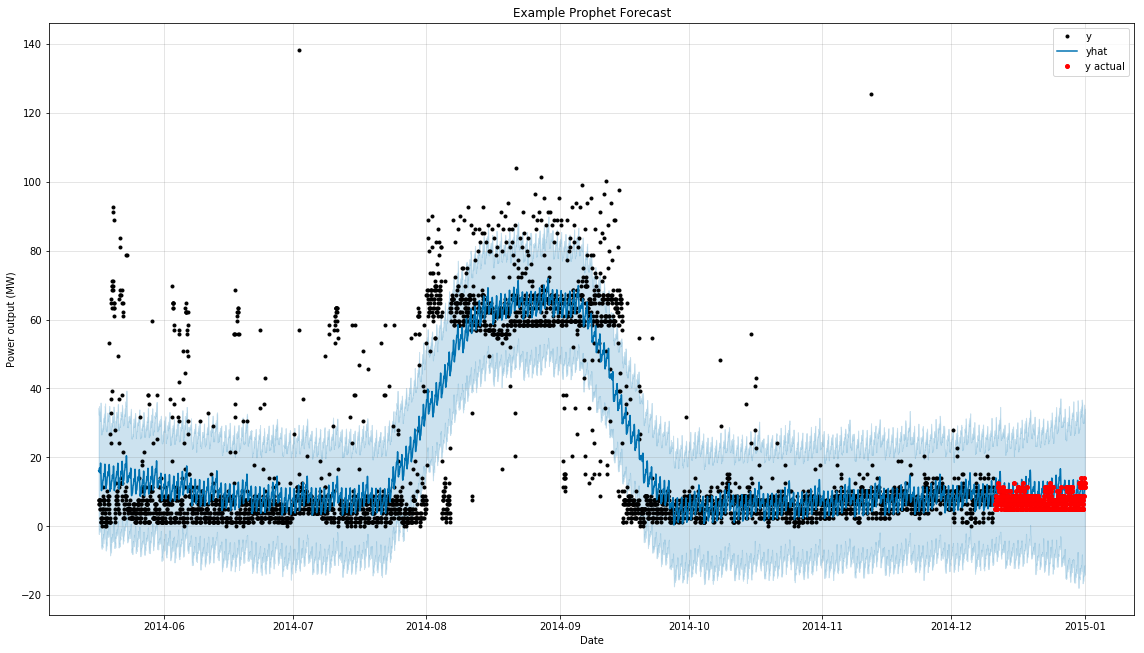

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
m.plot(forecast, ax=ax, xlabel='Date', ylabel='Power output (MW)')
ax.plot_date(forecast.loc[forecast['training'] == 0, 'ds'], forecast.loc[forecast['training'] == 0, 'y'],
             c='r', markersize=4, label='y actual')
ax.set_title('Example Prophet Forecast')
ax.legend();

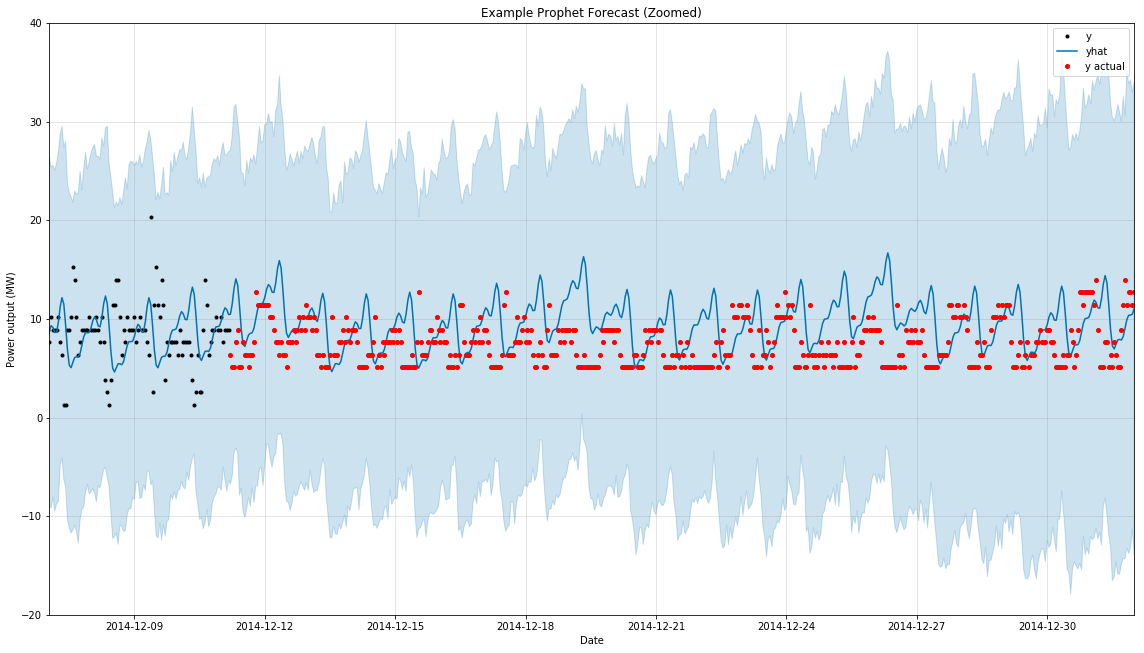

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
m.plot(forecast, ax=ax, xlabel='Date', ylabel='Power output (MW)')
ax.plot_date(forecast.loc[forecast['training'] == 0, 'ds'], forecast.loc[forecast['training'] == 0, 'y'],
             c='r', markersize=4, label='y actual')
ax.set_title('Example Prophet Forecast (Zoomed)')
ax.legend()
ax.set_xlim(forecast['ds'].iloc[-int(test_length*1.2)], forecast['ds'].iloc[-1])
ax.set_ylim(-20, 40);

# Evaluating Prophet

To evaluate Prophet, predictions will be generated for all time series in the CSP dataset, using the Model 1 approach outlined above (with subsequent zeroing of the negative values). Scaled RMSE will be calculated for each individual time series, and the mean of all these scores will be used as an overall accuracy metric for Prophet on this dataset.

In [10]:
results = hec[-(train_length+test_length):].copy()
results['training'] = 0
results['training'][:train_length] = 1

tic = time()
for i, col in enumerate(hec.columns[1:]):
    if i % 10 == 0:
        toc = time()
        print("Running predictions for column {}. Cumulative time {:.2f}s.".format(col, toc-tic))
        
    # Prepare DataFrame for selected column
    df = hec[['DateTime', col]].copy()
    df = df.iloc[-(train_length+test_length):]
    df.columns = ['ds', 'y']

    # Fit model and make predictions
    m = Prophet()
    m.fit(df[:train_length])
    fcst = m.predict(df)
    
    # Store results
    results['%s_pred' % col] = fcst['yhat'].values

C:\Users\aidan\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\aidan\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Running predictions for column household_0. Cumulative time 0.00s.


C:\Users\aidan\Anaconda3\lib\site-packages\fbprophet\forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()
C:\Users\aidan\Anaconda3\lib\site-packages\fbprophet\forecaster.py:1134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  seasonal = np.matmul(seasonal_features.as_matrix(), beta) * self.y_scale
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to o

Running predictions for column household_10. Cumulative time 140.32s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_20. Cumulative time 271.39s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_30. Cumulative time 400.80s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_40. Cumulative time 524.10s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_50. Cumulative time 666.02s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_60. Cumulative time 791.30s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_70. Cumulative time 914.97s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_80. Cumulative time 1043.95s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_90. Cumulative time 1158.02s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_100. Cumulative time 1289.44s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_110. Cumulative time 1413.36s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_120. Cumulative time 1587.12s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_130. Cumulative time 1709.04s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_140. Cumulative time 1831.39s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_150. Cumulative time 1967.81s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_160. Cumulative time 2115.51s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_170. Cumulative time 2270.00s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_180. Cumulative time 2436.67s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_190. Cumulative time 2588.76s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_200. Cumulative time 2724.79s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_210. Cumulative time 2866.97s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_220. Cumulative time 3020.97s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_230. Cumulative time 3153.21s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_240. Cumulative time 3302.87s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_250. Cumulative time 3435.98s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_260. Cumulative time 3583.69s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_270. Cumulative time 3717.76s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_280. Cumulative time 3856.74s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_290. Cumulative time 3991.98s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_300. Cumulative time 4121.95s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_310. Cumulative time 4255.51s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column household_320. Cumulative time 4383.33s.


In [11]:
results0 = results.iloc[:, 1:].copy()
results0[results0 < 0] = 0
results0['DateTime'] = results['DateTime']

In [12]:
results0.head()

,household_0,household_1,household_2,household_3,household_4,household_5,household_6,household_7,household_8,household_9,household_10,household_11,household_12,household_13,household_14,household_15,household_16,household_17,household_18,household_19,household_20,household_21,household_22,household_23,household_24,household_25,household_26,household_27,household_28,household_29,household_30,household_31,household_32,household_33,household_34,household_35,household_36,household_37,household_38,household_39,household_40,household_41,household_42,household_43,household_44,household_45,household_46,household_47,household_48,household_49,household_50,household_51,household_52,household_53,household_54,household_55,household_56,household_57,household_58,household_59,household_60,household_61,household_62,household_63,household_64,household_65,household_66,household_67,household_68,household_69,household_70,household_71,household_72,household_73,household_74,household_75,household_76,household_77,household_78,household_79,household_80,household_81,household_82,household_83,household_84,household_85,household_86,household_87,household_88,household_89,household_90,household_91,household_92,household_93,household_94,household_95,household_96,household_97,household_98,household_99,household_100,household_101,household_102,household_103,household_104,household_105,household_106,household_107,household_108,household_109,household_110,household_111,household_112,household_113,household_114,household_115,household_116,household_117,household_118,household_119,household_120,household_121,household_122,household_123,household_124,household_125,household_126,household_127,household_128,household_129,household_130,household_131,household_132,household_133,household_134,household_135,household_136,household_137,household_138,household_139,household_140,household_141,household_142,household_143,household_144,household_145,household_146,household_147,household_148,household_149,household_150,household_151,household_152,household_153,household_154,household_155,household_156,household_157,household_158,household_159,household_160,household_161,household_162,household_163,household_164,household_165,household_166,household_167,household_168,household_169,household_170,household_171,household_172,household_173,household_174,household_175,household_176,household_177,household_178,household_179,household_180,household_181,household_182,household_183,household_184,household_185,household_186,household_187,household_188,household_189,household_190,household_191,household_192,household_193,household_194,household_195,household_196,household_197,household_198,household_199,household_200,household_201,household_202,household_203,household_204,household_205,household_206,household_207,household_208,household_209,household_210,household_211,household_212,household_213,household_214,household_215,household_216,household_217,household_218,household_219,household_220,household_221,household_222,household_223,household_224,household_225,household_226,household_227,household_228,household_229,household_230,household_231,household_232,household_233,household_234,household_235,household_236,household_237,household_238,household_239,household_240,household_241,household_242,household_243,household_244,household_245,household_246,household_247,household_248,household_249,household_250,household_251,household_252,household_253,household_254,household_255,household_256,household_257,household_258,household_259,household_260,household_261,household_262,household_263,household_264,household_265,household_266,household_267,household_268,household_269,household_270,household_271,household_272,household_273,household_274,household_275,household_276,household_277,household_278,household_279,household_280,household_281,household_282,household_283,household_284,household_285,household_286,household_287,household_288,household_289,household_290,household_291,household_292,househo

In [13]:
sRMSEs = []
for i in range(0, len(hec.columns)-1):
    RMSE = np.sqrt(np.mean(np.square(results0.loc[results0['training'] == 0, 'household_%s' % i] - results0.loc[results0['training'] == 0, 'household_%s_pred' % i])))
    scale = np.mean(results0.loc[results0['training'] == 0, 'household_%s' % i])
    sRMSE = RMSE/scale
    sRMSEs.append(sRMSE)

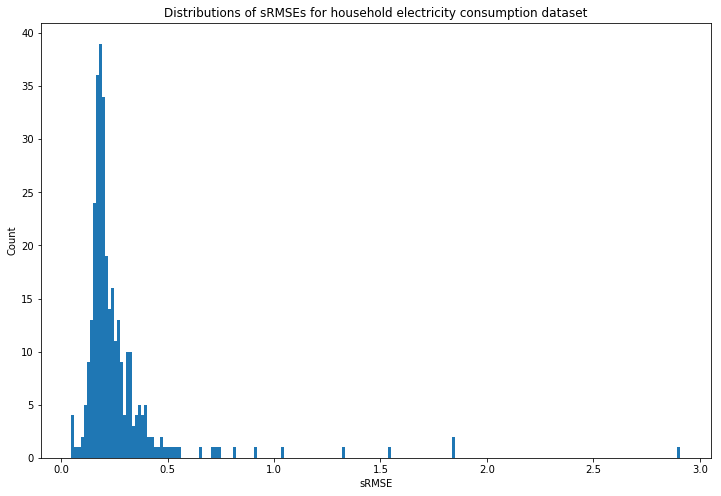

In [14]:
plt.hist(sRMSEs, bins=200)
plt.title('Distributions of sRMSEs for household electricity consumption dataset')
plt.xlabel('sRMSE')
plt.ylabel('Count');

In [15]:
sRMSE = np.mean(sRMSEs)
sRMSE

0.26500097523097565

Some example forecasts.

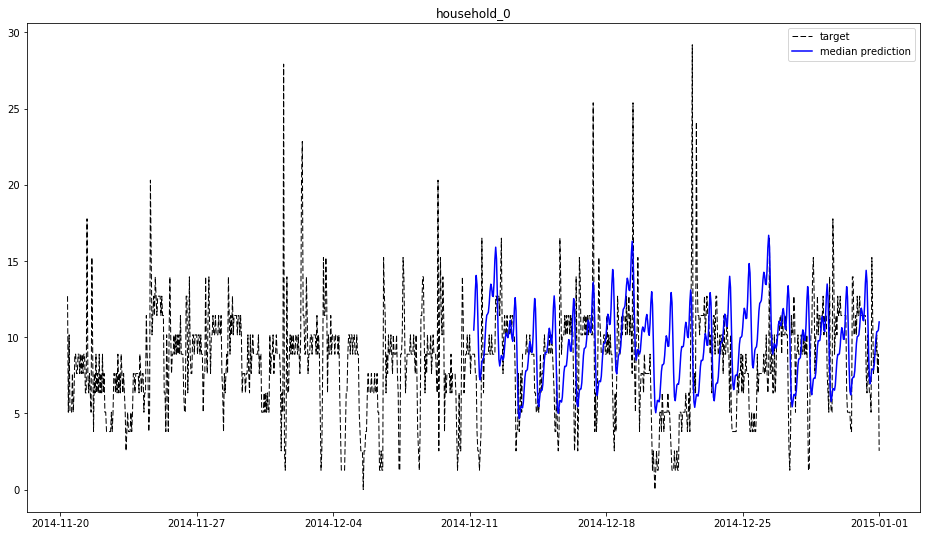

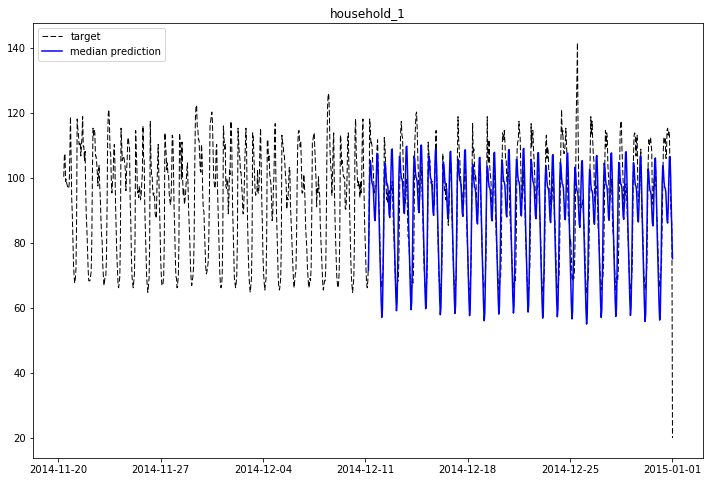

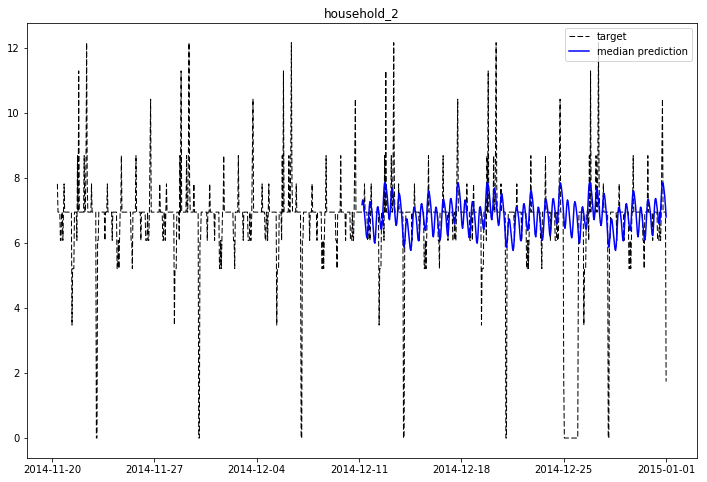

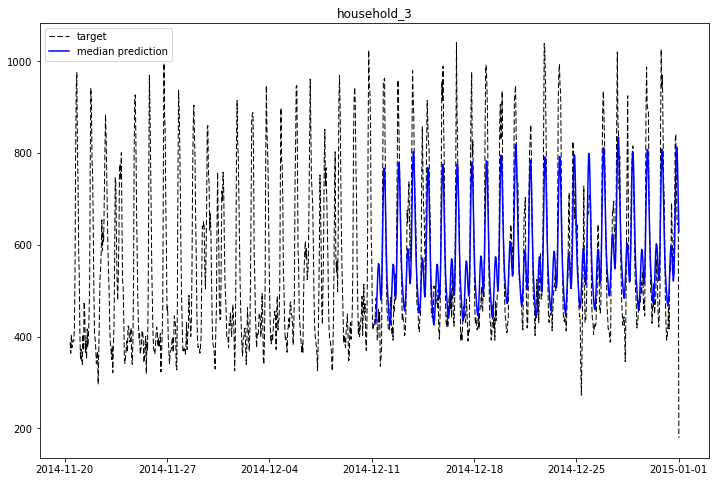

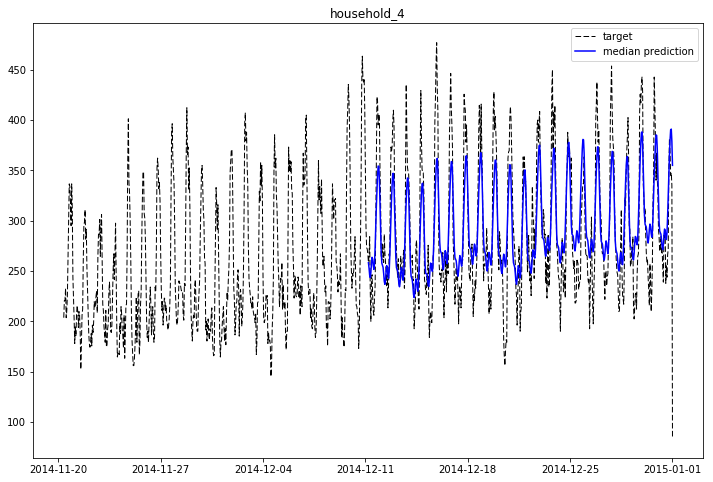

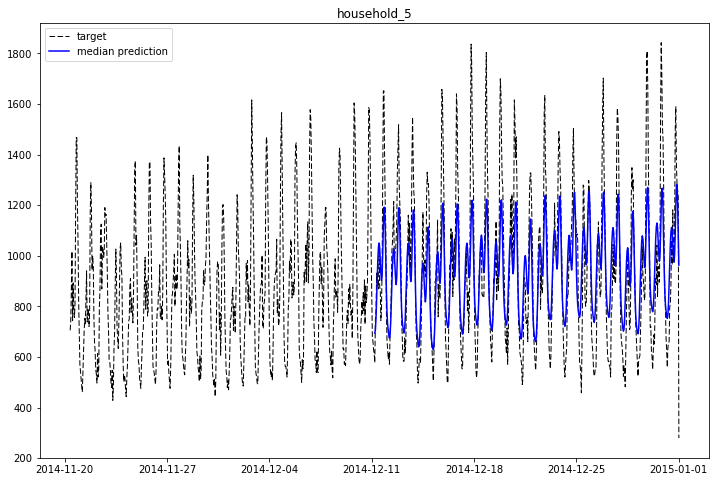

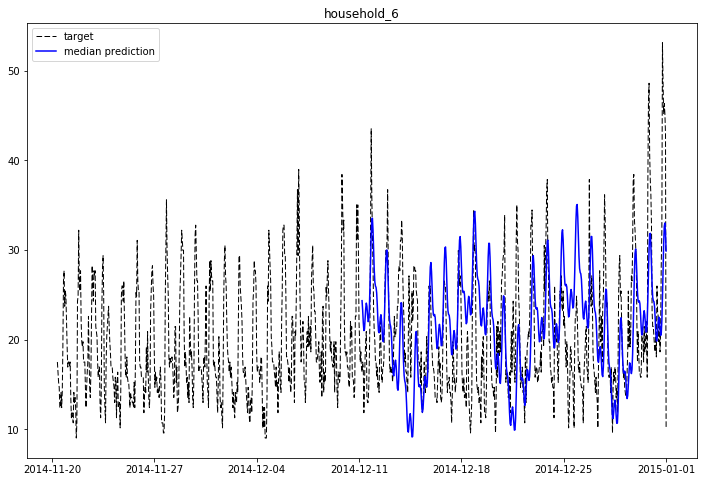

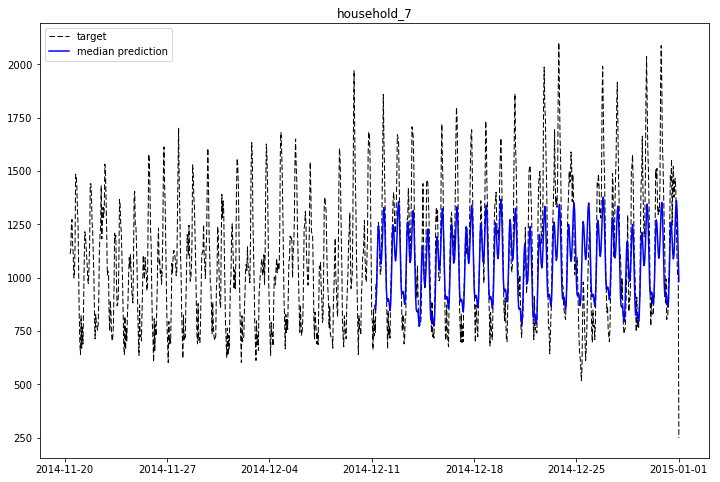

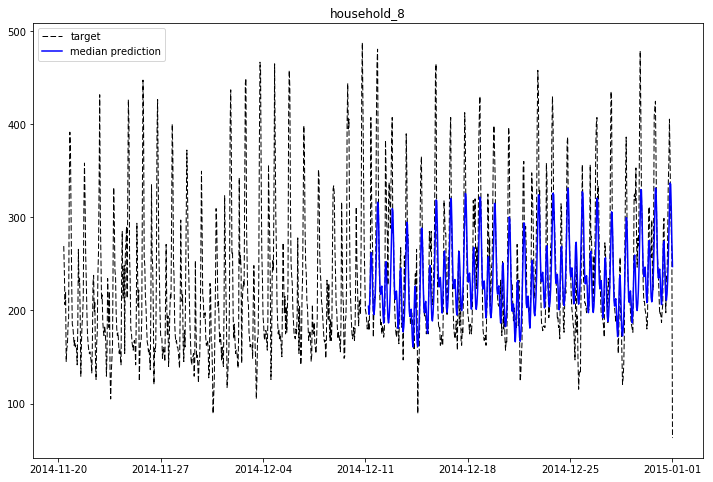

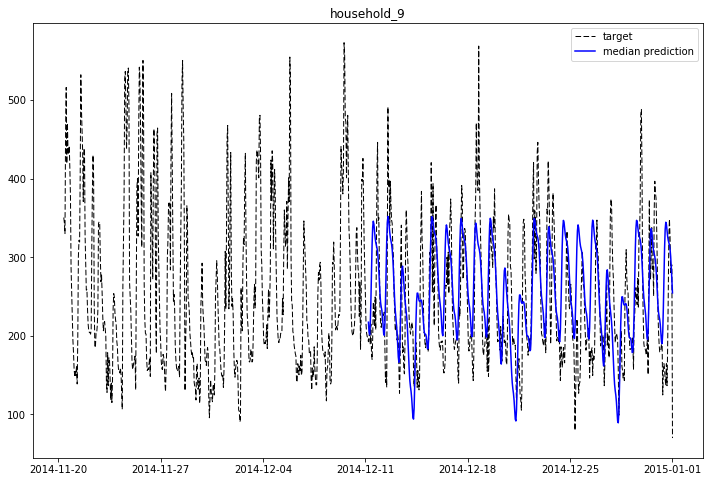

In [25]:
fig = plt.figure(figsize=(16, 9))
for household in range(10):
    plt.plot(results0['DateTime'][-1000:], results0['household_%s' % household][-1000:],
             label='target', c='k', linestyle='--', linewidth=1)
    plt.plot(results0['DateTime'][-500:], results0['household_%s_pred' % household][-500:], label='median prediction', c='b')
    plt.legend()
    plt.title('household_%s' % household)
    plt.show()

Store the raw results and the computed sRMSE accuracy score for the Prophet models.

In [19]:
import pickle

with open('hec-results.pkl', 'wb') as f:
    pickle.dump(results, f)
    
with open('hec-sRMSE.pkl', 'wb') as f:
    pickle.dump(sRMSE, f)